In [2]:
####### 
# Script to read in counter units and return mGal for gravity processing 
# added on verde spline interpolation 

#by Andrea Balza Morales
#modified Leo Uieda's work by Tomasz Gluzinski

#%%
import pandas as pd
import numpy as np 
#import verde as vd
#import harmonica as hm
#import xarray as xr
#import pyproj
import matplotlib.pyplot as plt
#import boule as bl
import csv as csv
#import rasterio

from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed

In [7]:
#From calibration table
#Creating the calibration table with all of the values from the PDF (G-453)
cr_value = np.arange(0,7000,100)
cr_value

mGal = [000.00,102.16,204.31,306.46,408.60,510.74,612.38,715.02,817.17,919.32,1021.48,1123.65,1225.82,1328.00,1430.19,1532.39,1634.60,
1736.92,1839.04,1941.28,2043.54,2145.80,2249.08,2350.37,2452.6,2554.99,2657.32,2759.67,2862.03,2964.40,3066.78,3169.15,3271.59,3374.00,
3476.43,3578.87,3681.32,3783.78,3889.25,3989.73,4091.21,4193.71,4296.21,4398.72,4501.24,4603.77,4706.30,4808.83,4911.37,5013.91,5116.45,
5218.99,5321.53,5424.07,5526.61,5629.14,5731.67,5834.20,5936.72,6039.23,6141.73,6244.22,6346.68,6449.14,6551.57,6653.98,6756.37,
6858.73,6961.07,7063.38]

factor = [1.02162,1.02151,1.02145,1.02141,1.02140,1.02141,1.02144,1.02147,1.02153,1.02159,1.02165,1.02173,1.02181,1.02189,1.02198,1.02208,
1.02218,1.02228,1.02240,1.02252,1.02264,1.02276,1.0220,1.02304,1.02319,1.02332,1.02346,1.02359,1.02372,1.02384,1.02396,1.02408,1.02419,1.02429,
1.02439,1.02450,1.02459,1.02468,1.02478,1.02487,1.02495,1.02503,1.02511,1.02518,1.02525,1.02530,1.02533,1.02538,1.02541,1.02542,1.02541,
1.02540,1.02539,1.02537,1.02535,1.02531,1.02526,1.02519,1.02512,1.02501,1.02486,1.02468,1.02451,1.02432,1.02411,1.02389,1.02365,1.02339,1.02309,1.02275]

# %%

In [8]:
#Create data frame for
cal_table = pd.DataFrame(np.column_stack([cr_value,mGal,factor]), columns=['Cr_value', 'mGal', 'factor'])
cal_table.head()

,Cr_value,mGal,factor
0,0.0,0.00,1.02162
1,100.0,102.16,1.02151
2,200.0,204.31,1.02145
3,300.0,306.46,1.02141
4,400.0,408.60,1.02140


In [9]:
gpsdf = pd.read_csv('C:/RWTH_Aachen/thesis/backup_gravity_mod/StraelenGravityProc/StraelenGPS_2.csv', header=15)
data = pd.read_excel('C:/RWTH_Aachen/thesis/backup_gravity_mod/StraelenGravityProc/Gravity_Measurements_Dec2022.xlsx')
dataset = rasterio.open('C:/RWTH_Aachen/thesis/backup_gravity_mod/StraelenGravityProc/DEM1_Andrea.tif')

data.head()
data['Counter Reading'] = data['Counter Reading']/10
# %%

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

In [5]:
def counter_to_mGal(counter, cal_table):
    """Converts the counter value to mGal with the given Calibration Table

    Args:
        counter (float): Counter value from the L&R meter
        cal_table (Pandas dataframe) : Dataframe of the calibration table

    Returns:
        array of floats: mGal value of counter units
    """
    counterw = int(counter/100)*100
    indexval = cal_table['Cr_value'].loc[lambda x: x==counterw].index
    res =  counter - cal_table['Cr_value'][indexval]
    resmult = res*cal_table['factor'][indexval]
    mGalvalue = resmult + cal_table['mGal'][indexval]
    return float(mGalvalue)

In [6]:
#Apply the function to the dataframe (date)
Counteru = np.array(data['Counter Reading'])
mGalvalues = []
for cu in Counteru:
    mGalv = counter_to_mGal(cu, cal_table)
    mGalvalues.append(mGalv)
data['Observed Value [mGal]'] = mGalvalues

In [7]:
#Load the GPS data and create a dataframe
gpsdf.drop(gpsdf.tail(12).index,inplace=True) # drop last n rows
gpsdf = gpsdf[['ID', 'lat', 'lon', 'ele', 'time', 'cmt', 'name']]


In [8]:
#Change the type of column and translate all of the strings to float values
gpsdf['name'] = gpsdf['name'].astype(str).astype(int)
gpsdf['ele'] = gpsdf['ele'].astype(str).astype(float)
gpsdf['lat'] = gpsdf['lat'].astype(str).astype(float)
gpsdf['lon'] = gpsdf['lon'].astype(str).astype(float)

In [9]:
#Merge both the gps dataframe and the gravity dataframe given the Point ID
dffinal = data.merge(gpsdf, how="left", left_on='Point ID', right_on='name')

In [10]:
#Convert the lat long values to X and Y coordinates
pnew = pyproj.Proj(proj='utm', zone=32, hemisphere='N', ellps='WGS84', preserve_units=False)
dffinal['x'], dffinal['y'] = pnew(dffinal.lon.values, dffinal.lat.values)

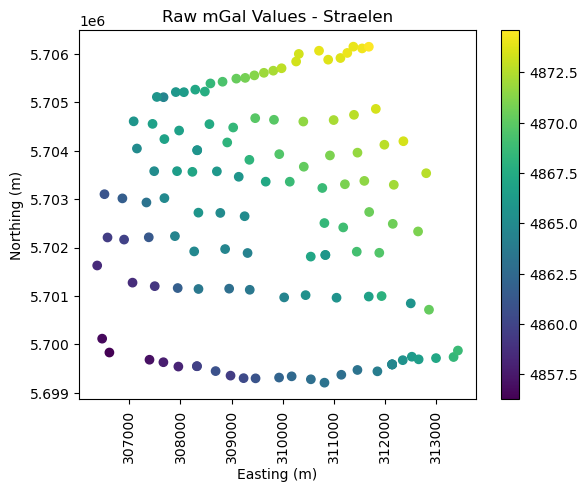

In [11]:
#Plotting the observed value
plt.scatter(dffinal['x'], dffinal['y'], c=dffinal['Observed Value [mGal]'])
plt.xticks(rotation=90)
plt.colorbar()
plt.title('Raw mGal Values - Straelen' )
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.plot()
plt.show()

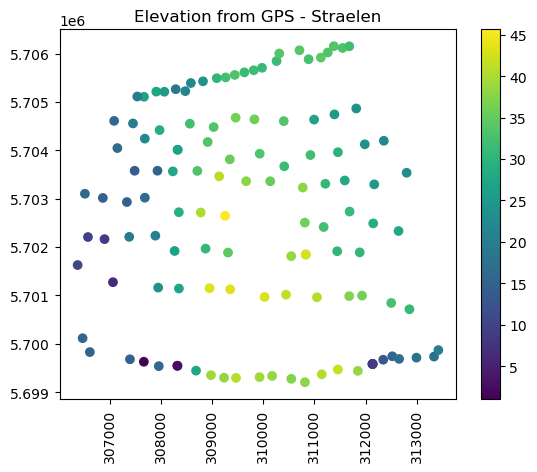

In [12]:
#Plotting the GPS elevation
plt.scatter(dffinal['x'], dffinal['y'], c=dffinal['ele'])
plt.xticks(rotation=90)
plt.colorbar()
plt.title('Elevation from GPS - Straelen' )
plt.plot()
plt.show()


In [13]:
#Importing the topo grid from ICGEM : Very coarse since this is 1 arc degree data
#topo_grid = hm.load_icgem_gdf('C:/Users/tgluz/anaconda3/envs/gravity_str/StraelenGravityProc/etopo1-2250_eead0e2e970d3910d8f5abced00d8403c441079c521bb80cc935e9bbe71d2410.gdf')
#topo_grid.topography_grd.plot()

#importing tiff DEM instead

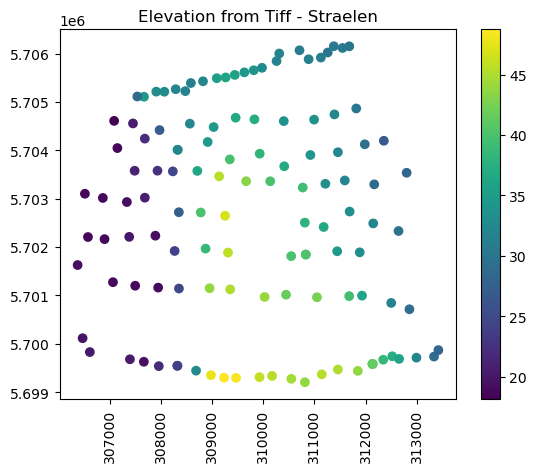

In [14]:
#Importing tiff
band1 = dataset.read(1)
indexes = dataset.index(dffinal['x'], dffinal['y'])
dffinal['Ele_tiff'] = band1[indexes]

#%%
plt.scatter(dffinal['x'], dffinal['y'], c=dffinal['Ele_tiff'])
plt.xticks(rotation=90)
plt.colorbar()
plt.title('Elevation from Tiff - Straelen' )
plt.plot()
plt.show()

## Drift Corrections

In [15]:
#drift correction day 1
base_day1=dffinal['Observed Value [mGal]'].loc[0]
print('Base station start of the day 1')
base_day1

Base station start of the day 1


4864.71321

In [16]:
end_day1=dffinal['Observed Value [mGal]'].loc[18]
print('Base station end of the day 1')
end_day1

Base station end of the day 1


4864.71321

In [17]:
drift1=base_day1-end_day1
drift1

0.0

In [18]:
#drift correction day 2
base_day2=dffinal['Observed Value [mGal]'].loc[19]
print('Base station day 2')
base_day2

Base station day 2


4864.71321

In [19]:
end_day2=dffinal['Observed Value [mGal]'].loc[48]
print('Base station end of the day 2')
end_day2

Base station end of the day 2


4864.71321

In [20]:
drift2=base_day2-end_day2
drift2

0.0

In [21]:
#drift correction day 3
base_day3=dffinal['Observed Value [mGal]'].loc[49]
print('Base station day 3')
base_day3

Base station day 3


4859.893924

In [22]:
end_day3=dffinal['Observed Value [mGal]'].loc[76]
print('Base station end of the day 3')
end_day3

Base station end of the day 3


4859.791386

In [23]:
drift3=base_day3-end_day3
drift3

0.10253800000009505

In [24]:
import datetime

In [25]:
#Drift non zero, calculate drift factor
time_begin_day3=dffinal['Time'].loc[49]
time_begin_day3

Timestamp('1900-01-01 12:58:00')

In [26]:
time_finish_day3=dffinal['Time'].loc[76]
time_finish_day3

Timestamp('1900-01-01 18:44:00')

In [27]:
time_delta3=(time_finish_day3-time_begin_day3)
time_delta3

Timedelta('0 days 05:46:00')

In [28]:
#Transfering Timedelta to minutes
td3=time_delta3.total_seconds()/60
td3

346.0

In [29]:
#day 3 drift factor
d3d=drift3/td3
d3d


0.0002963526011563441

In [30]:
#drift correction day 4
base_day4=dffinal['Observed Value [mGal]'].loc[77]
print('Base station day 4')
base_day4

Base station day 4


4865.841128

In [31]:
end_day4=dffinal['Observed Value [mGal]'].loc[123]
print('Base station end of the day 4')
end_day4

Base station end of the day 4


4865.73859

In [32]:
drift4=base_day4-end_day4
drift4

0.10253800000009505

In [33]:
#Drift non zero, calculate drift factor
time_begin_day4=dffinal['Time'].loc[77]
time_begin_day4

Timestamp('1900-01-01 10:35:00')

In [34]:
time_finish_day4=dffinal['Time'].loc[123]
time_finish_day4

Timestamp('1900-01-01 16:06:00')

In [35]:
time_delta4=(time_finish_day4-time_begin_day4)
time_delta4

Timedelta('0 days 05:31:00')

In [36]:
#Transfering Timedelta to minutes
td4=time_delta4.total_seconds()/60
td4

331.0

In [37]:
#day 4 drift factor
d4d=drift4/td4
d4d


0.0003097824773416769

In [38]:
#date converted into lenght of survey in separate excel spreadsheet,
#loading lenght of the survey in minutes as a separate column from csv file, zeros for first two days, as no drift used
minutes = pd.read_csv('C:/RWTH_Aachen/thesis/backup_gravity_mod/modification_of_research_module/time_in_minutes.csv')

dffinal['minutes']=minutes['time_in_minutes']

In [39]:
#creating additional column with drift factors for day 3 and 4 
dffinal.loc[0:45, 'drift factor'] = 0
dffinal.loc[46:76, 'drift factor'] = d3d
dffinal.loc[77:123, 'drift factor'] = d4d

In [40]:
#drift corrected value
dffinal['Corrected Value [mGal]'] = dffinal['Observed Value [mGal]'] - (dffinal['minutes']*dffinal['drift factor'])


## Calculate absolute gravity

Now that we have our relative readings in mGal, we can tie them to the base station and calculate absolute gravity:

$$ g_{station} = (r_{station} - r_{base}) + g_{base} $$

The first thing we need to do is calculate the difference between the readings and the base station (station 0).

Closest bases station is Dusseldorf Airport
http://bgidata.get.obs-mip.fr/cre_sketch_station.php?numref=101601&ordre=1&g=981097076

there were 4 base stations as the data was collected over 4 days [accordingly 0, 19, 46 and 77 in the csv file] 

In [41]:
dffinal.loc[0:18, 'Reading difference [mGal]'] =  dffinal['Corrected Value [mGal]'] - dffinal['Corrected Value [mGal]'].loc[0]
dffinal.loc[19:45, 'Reading difference [mGal]'] =  dffinal['Corrected Value [mGal]'] - dffinal['Corrected Value [mGal]'].loc[19]
dffinal.loc[46:76, 'Reading difference [mGal]'] =  dffinal['Corrected Value [mGal]'] - dffinal['Corrected Value [mGal]'].loc[46]
dffinal.loc[77:123, 'Reading difference [mGal]'] =  dffinal['Corrected Value [mGal]'] - dffinal['Corrected Value [mGal]'].loc[77]

In [42]:
dffinal['abs_Grav'] = dffinal['Reading difference [mGal]'] + 981184.480

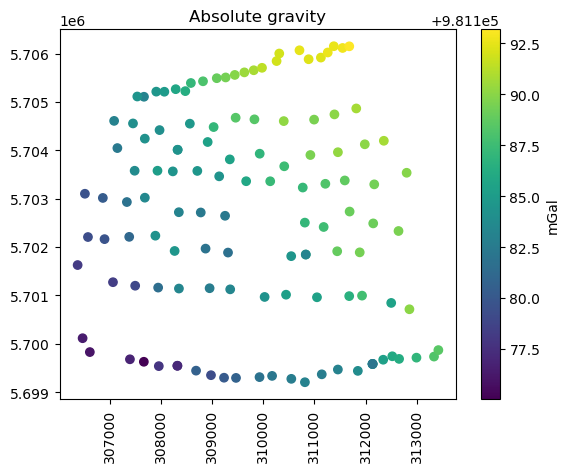

In [43]:
#%%
plt.scatter(dffinal['x'], dffinal['y'], c=dffinal['abs_Grav'])
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.title("Absolute gravity")
plt.plot()
plt.show()

In [44]:
def somigliana(latitude):
    """
    Calculate normal gravity using the Somigliana equation.
    The ellipsoid used is WGS84.
    """
    semimajor = 6_378_137
    semiminor = 6_356_752
    # Convert to m/s² so the units are compatible
    gamma_equator = 9.7803253359
    gamma_pole = 9.8321849379
    # Calculate these in advance since we use them twice
    cos_lat2 = np.cos(np.radians(latitude)) ** 2
    sin_lat2 = np.sin(np.radians(latitude)) ** 2
    normal_gravity_surface = (
        (semimajor * gamma_equator * cos_lat2 + semiminor * gamma_pole * sin_lat2) /
        np.sqrt(semimajor ** 2 * cos_lat2 + semiminor ** 2 * sin_lat2)
    )
    # Convert from m/s² to mGal before returning
    return normal_gravity_surface * 1e5

In [45]:
#elevation correction from Leo
def somigliana_with_height(latitude, height):
    """
    Calculate normal gravity at the given latitude and height.
    Uses the Somgliana equation to calculate on the surface of 
    the ellipsoid and the free-air correction to upward continue
    to the given height.
    """
    gamma_0 = somigliana(latitude)
    gamma = gamma_0 - 0.3086 * height
    return gamma

In [46]:
elev_normal_gravity = somigliana_with_height(dffinal['lat'], dffinal['Ele_tiff'])

In [47]:
dffinal['Elevation_corrected_normal']=elev_normal_gravity


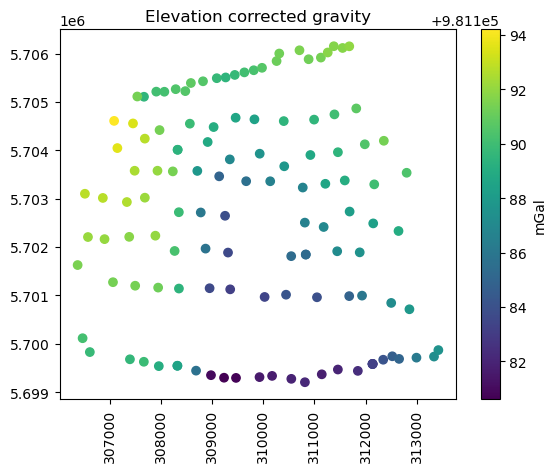

In [48]:
plt.scatter(dffinal['x'], dffinal['y'], c=elev_normal_gravity)
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.title('Elevation corrected gravity' )
plt.plot()
plt.show()

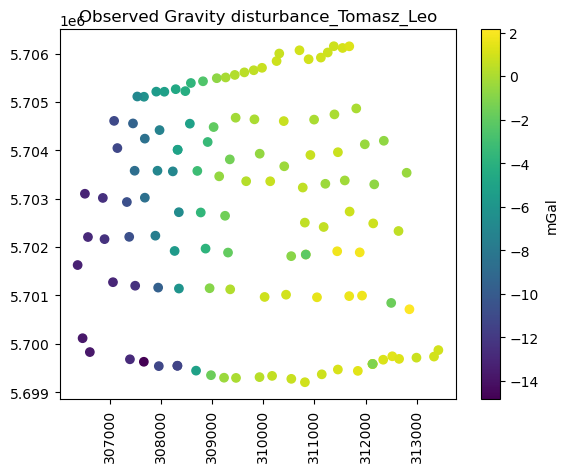

In [49]:
dffinal['gravity_disturbance_Tomasz_Leo'] = dffinal['abs_Grav'] - dffinal['Elevation_corrected_normal']
plt.scatter(dffinal['x'], dffinal['y'], c=dffinal['gravity_disturbance_Tomasz_Leo'])
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.title('Observed Gravity disturbance_Tomasz_Leo' )
plt.plot()
plt.show()

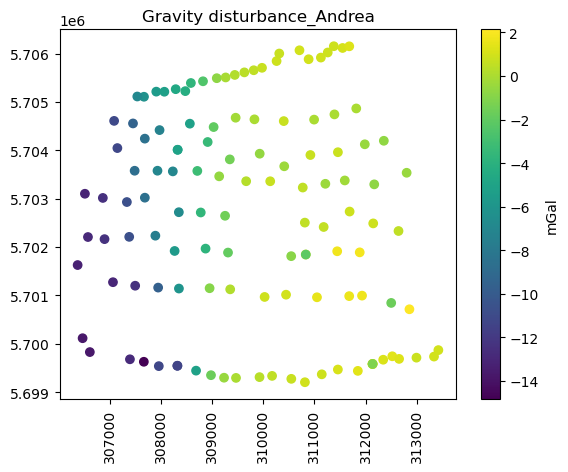

In [50]:
#Andrea's version
#Calculating theoretical gravity and subtracting from observed Value
#Note: This should be done after tying the observed gravity value to the base
#elevation model from the tiff file - another method
ell = bl.WGS84
dffinal['Theo_Grav'] = ell.normal_gravity(dffinal.lat, dffinal.Ele_tiff)
dffinal['gravity_disturbance_Andrea'] = dffinal['abs_Grav'] - dffinal['Theo_Grav']

plt.scatter(dffinal['x'], dffinal['y'], c=dffinal['gravity_disturbance_Andrea'])
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.title('Gravity disturbance_Andrea' )
plt.plot()
plt.show()

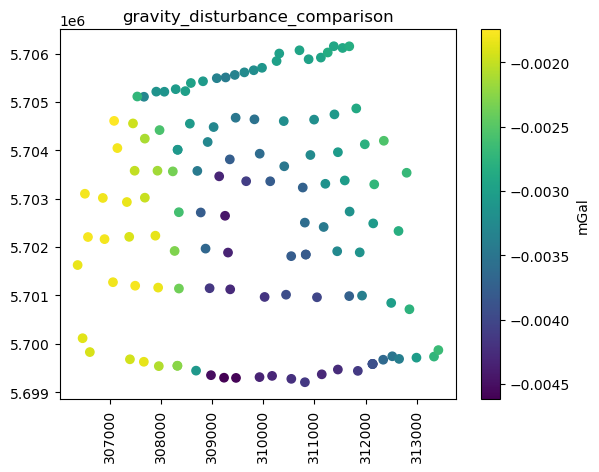

In [51]:
#comparing disturbance by Andrea and Leo/Tomasz
dffinal['gravity_disturbance_comparison']=dffinal['gravity_disturbance_Andrea']-dffinal['gravity_disturbance_Tomasz_Leo']
plt.scatter(dffinal['x'], dffinal['y'], c=dffinal['gravity_disturbance_comparison'])
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.title('gravity_disturbance_comparison')
plt.plot()
plt.show()

That looks as if the code did not thake into the consideration the elevation from the tiff

ell = bl.WGS84

dffinal['Theo_Grav'] = ell.normal_gravity(dffinal.lat, dffinal.Ele_tiff)

dffinal['gravity_disturbance_Andrea'] = dffinal['abs_Grav'] - dffinal['Theo_Grav']

In [52]:
def bouguer_plate(thickness, density):
    """
    Calculate the gravitational attraction of an infinity slab.
    """
    grav_const = 6.67430e-11  # SI
    # Convert from m/s² to mGal
    result = 1e5 * 2 * np.pi * grav_const * density * thickness
    return result

In [53]:
gravity_bouguer = dffinal['gravity_disturbance_Tomasz_Leo'] - bouguer_plate(thickness=dffinal['Ele_tiff'], density=2670)

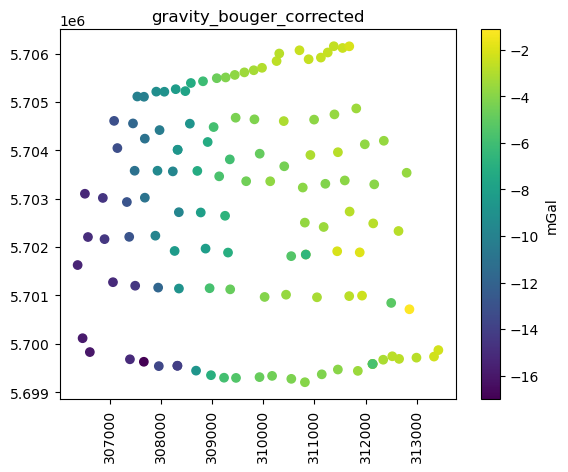

In [54]:
dffinal['gravity_bouger_corrected']=gravity_bouguer


plt.scatter(dffinal['x'], dffinal['y'], c=dffinal['gravity_bouger_corrected'])
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.title('gravity_bouger_corrected')
plt.plot()
plt.show()

## testing Bouger response based on different densities of the slab 

In [55]:

gravity_bouguer1800 = dffinal['gravity_disturbance_Tomasz_Leo'] - bouguer_plate(thickness=dffinal['Ele_tiff'], density=1800)

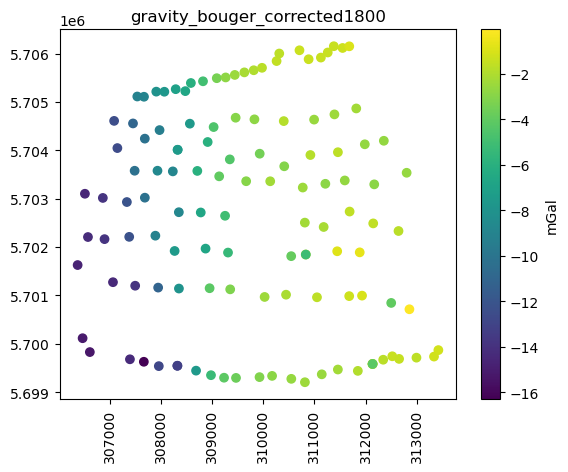

In [56]:
dffinal['gravity_bouger_corrected1800']=gravity_bouguer1800

plt.scatter(dffinal['x'], dffinal['y'], c=dffinal['gravity_bouger_corrected1800'])
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.title('gravity_bouger_corrected1800')
plt.plot()
plt.show()

In [57]:

gravity_bouguer2000 = dffinal['gravity_disturbance_Tomasz_Leo'] - bouguer_plate(thickness=dffinal['Ele_tiff'], density=2000)

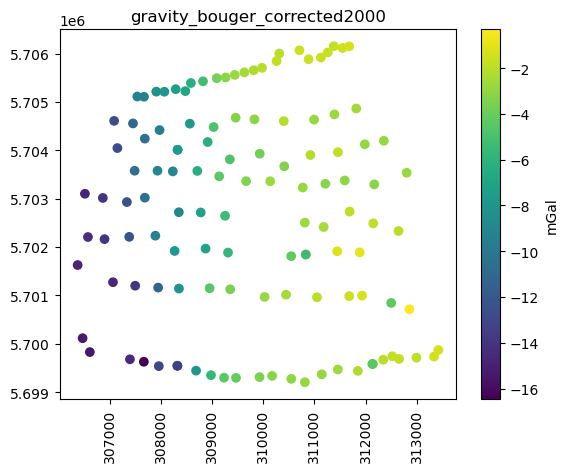

In [58]:
dffinal['gravity_bouger_corrected2000']=gravity_bouguer2000

plt.scatter(dffinal['x'], dffinal['y'], c=dffinal['gravity_bouger_corrected2000'])
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.title('gravity_bouger_corrected2000')
plt.plot()
plt.show()

In [59]:
gravity_bouguer2200 = dffinal['gravity_disturbance_Tomasz_Leo'] - bouguer_plate(thickness=dffinal['Ele_tiff'], density=2200)

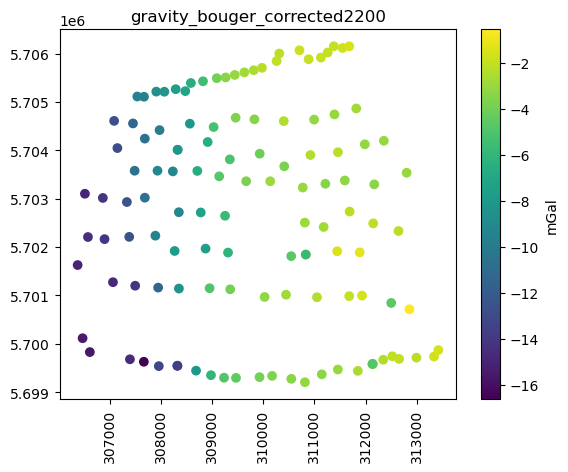

In [60]:
dffinal['gravity_bouger_corrected2200']=gravity_bouguer2200

plt.scatter(dffinal['x'], dffinal['y'], c=dffinal['gravity_bouger_corrected2200'])
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.title('gravity_bouger_corrected2200')
plt.plot()
plt.show()

In [61]:
gravity_bouguer2400 = dffinal['gravity_disturbance_Tomasz_Leo'] - bouguer_plate(thickness=dffinal['Ele_tiff'], density=2400)

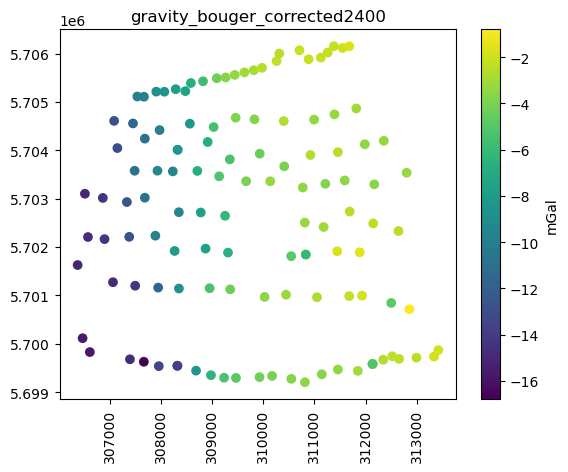

In [62]:
dffinal['gravity_bouger_corrected2400']=gravity_bouguer2400

plt.scatter(dffinal['x'], dffinal['y'], c=dffinal['gravity_bouger_corrected2400'])
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.title('gravity_bouger_corrected2400')
plt.plot()
plt.show()

In [63]:
gravity_bouguer2600 = dffinal['gravity_disturbance_Tomasz_Leo'] - bouguer_plate(thickness=dffinal['Ele_tiff'], density=2600)

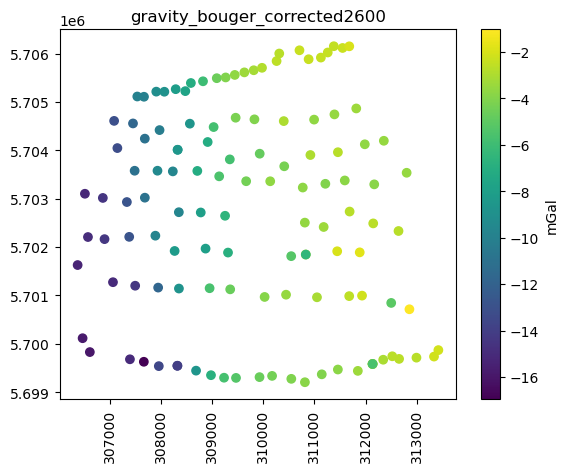

In [64]:
dffinal['gravity_bouger_corrected2600']=gravity_bouguer2600

plt.scatter(dffinal['x'], dffinal['y'], c=dffinal['gravity_bouger_corrected2600'])
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.title('gravity_bouger_corrected2600')
plt.plot()
plt.show()

In [1]:
gbdelta=dffinal['gravity_bouger_corrected2600']-dffinal['gravity_bouger_corrected1800']

for i, txt in enumerate(dffinal['ID']):
    plt.annotate(txt, (dffinal['x'][i], dffinal['y'][i]))


plt.scatter(dffinal['x'], dffinal['y'], c=gbdelta)
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.title('Impact of density choice (between 2600 and 1800)')
plt.plot()
plt.show()


NameError: name 'dffinal' is not defined

In [66]:
#Plotting impact on the density choice on 3 different points => one in the centre, one in the east and one in the west  

dffinal['bouger_rho_delta'] = gbdelta

dffinal_sub = dffinal.iloc[[83, 117, 120]]


In [67]:
dffinal_sub

,Point ID,Observed Value [mGal],Time,Voltage [V],Temperature [°C],Altitude,Counter Reading,Remark,Date,Profile,...,Theo_Grav,gravity_disturbance_Andrea,gravity_disturbance_comparison,gravity_bouger_corrected,gravity_bouger_corrected1800,gravity_bouger_corrected2000,gravity_bouger_corrected2200,gravity_bouger_corrected2400,gravity_bouger_corrected2600,bouger_rho_delta
83,5007,4861.021842,1900-01-01 11:24:00,12.6,50.0,16,4750.9,NaN,19.12.2022,NaN,...,981192.811722,-13.165766,-0.001798,-15.261142,-14.577793,-14.734885,-14.891976,-15.049068,-15.206160,-0.628367
117,5012,4870.968028,1900-01-01 15:28:00,12.6,49.9,28,4760.6,NaN,19.12.2022,NaN,...,981189.004695,0.513961,-0.002815,-2.806456,-1.723605,-1.972537,-2.221468,-2.470399,-2.719331,-0.995725
120,4010,4867.276660,1900-01-01 15:51:00,12.6,49.9,38,4757.0,city centre,19.12.2022,NaN,...,981185.573299,0.247062,-0.004095,-4.581974,-3.007134,-3.369166,-3.731198,-4.093230,-4.455263,-1.448130


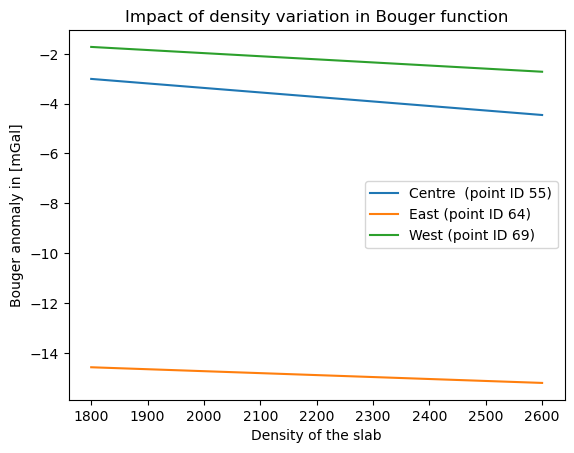

In [68]:
density = [1800, 2000, 2200, 2400, 2600]
east = [dffinal.loc[83, 'gravity_bouger_corrected1800'],
           dffinal.loc[83, 'gravity_bouger_corrected2000'],
           dffinal.loc[83, 'gravity_bouger_corrected2200'],
           dffinal.loc[83, 'gravity_bouger_corrected2400'],
           dffinal.loc[83, 'gravity_bouger_corrected2600'],
           ]
west = [dffinal.loc[117, 'gravity_bouger_corrected1800'],
           dffinal.loc[117, 'gravity_bouger_corrected2000'],
           dffinal.loc[117, 'gravity_bouger_corrected2200'],
           dffinal.loc[117, 'gravity_bouger_corrected2400'],
           dffinal.loc[117, 'gravity_bouger_corrected2600'],
           ]
centre = [dffinal.loc[120, 'gravity_bouger_corrected1800'],
           dffinal.loc[120, 'gravity_bouger_corrected2000'],
           dffinal.loc[120, 'gravity_bouger_corrected2200'],
           dffinal.loc[120, 'gravity_bouger_corrected2400'],
           dffinal.loc[120, 'gravity_bouger_corrected2600'],
           ]

plt.plot(density, centre, label='Centre  (point ID 55)')
plt.plot(density, east, label='East (point ID 64)')
plt.plot(density, west, label='West (point ID 69)')
plt.xlabel('Density of the slab')
plt.ylabel('Bouger anomaly in [mGal]')
plt.legend()
plt.title('Impact of density variation in Bouger function')
plt.show()


In [69]:
#calculationg and plotting regional
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
def estimate_trend(easting, northing, observations, degree):
    """
    Estimate a 2D polynomial regional trend that fits the observations.
    Returns the estimated trend values.
    """
    npoints = observations.size
    coordinates = np.empty((npoints, 2))
    coordinates[:, 0] = dffinal['lat']
    coordinates[:, 1] = dffinal['lon']
    
    features = PolynomialFeatures(degree)
    X = features.fit_transform(coordinates)

    polynomial = LinearRegression()
    polynomial.fit(X, observations)

    trend = polynomial.predict(X)
    return trend


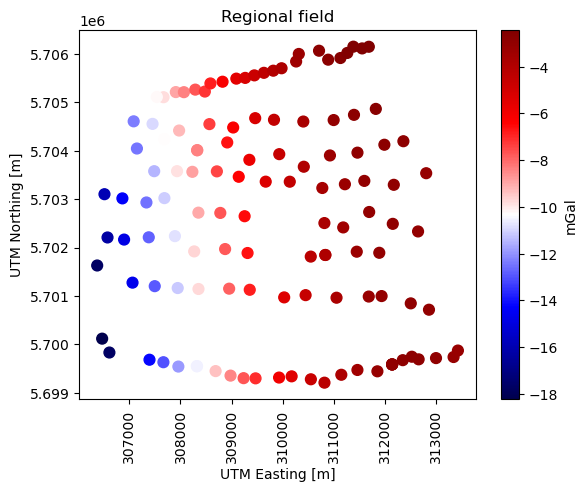

In [70]:
regional = estimate_trend(dffinal['x'], dffinal['y'], dffinal['gravity_bouger_corrected'], degree=2)


dffinal['regional'] = regional

plt.figure()
plt.scatter(dffinal['x'], dffinal['y'], c=dffinal['regional'] , s=60, cmap="seismic")
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.title("Regional field")
plt.show()


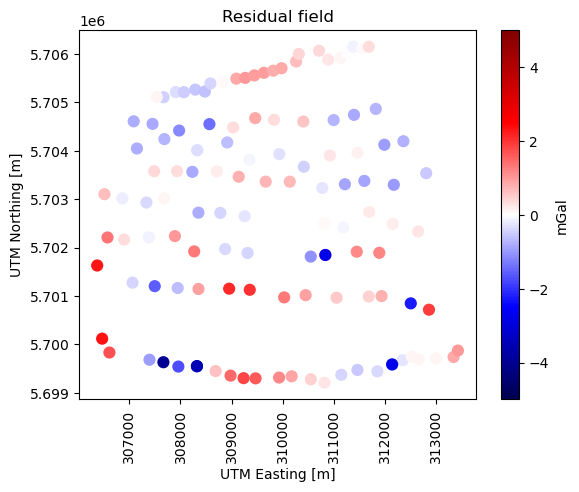

In [71]:
#residual
dffinal['residual']  = dffinal['gravity_bouger_corrected'] - dffinal['regional']

plt.figure()
plt.scatter(dffinal['x'], dffinal['y'], c=dffinal['residual'] , s=60, cmap="seismic", vmin=-5, vmax=5)
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.title("Residual field")
plt.show()



Spline()


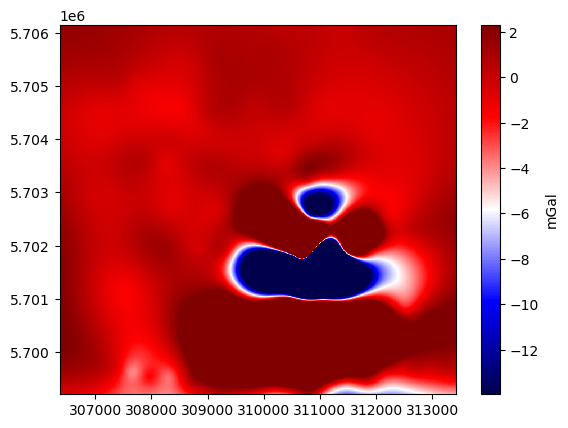

In [72]:
#%% Gridding residual
dffinal.dropna(subset=['residual'], inplace=True)
# #verde interpolation
spline = vd.Spline()
# Printing a gridder shows the class and all of it's configuration options.
coordinates = (np.array(dffinal['x']), np.array(dffinal['y']))
print(spline)
spline.fit(coordinates, np.array(dffinal['residual']))
# # Generate coordinates for a regular grid with 10 m grid spacing (assuming
# # coordinates are in meters).
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(region, spacing=10)
grid_residual = spline.predict(grid_coords)
#
plt.figure()
plt.pcolormesh(grid_coords[0], grid_coords[1], grid_residual, cmap="seismic", 
               vmin=dffinal['residual'].min()-10, vmax=dffinal['residual'].max())
plt.colorbar(label="mGal")
plt.show()
#


In [73]:
#%% Gridding residual CV try
dffinal.dropna(subset=['residual'], inplace=True)
# verde interpolation
# spline will automatically perform cross-validation and search for the 
# optimal parameter configuration. - https://www.fatiando.org/verde/latest/gallery/spline_cv.html#sphx-glr-gallery-spline-cv-py
spline = vd.SplineCV(dampings=(1e-5, 1e-3, 1e-1), mindists=(10e3, 50e3, 100e3))

# Printing a gridder shows the class and all of it's configuration options.
coordinates = (np.array(dffinal['x']), np.array(dffinal['y']))
print(spline)

spline.fit(coordinates, np.array(dffinal['residual']))
# # Generate coordinates for a regular grid with 10 m grid spacing (assuming
# # coordinates are in meters).
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(region, spacing=10)
grid_residual = spline.predict(grid_coords)


SplineCV(dampings=(1e-05, 0.001, 0.1), mindists=(10000.0, 50000.0, 100000.0))


C:\Users\tgluz\.conda\envs\plot_grav\lib\site-packages\verde\base\base_classes.py:359: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.0.0. This may change model selection results slightly.
  warnings.warn(
C:\Users\tgluz\.conda\envs\plot_grav\lib\site-packages\verde\base\base_classes.py:359: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.0.0. This may change model selection results slightly.
  warnings.warn(
C:\Users\tgluz\.conda\envs\plot_grav\lib\site-packages\verde\base\base_classes.py:359: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.0.0. This may change model selection results slightly.
  warnings.warn(
C:\Users\tgluz\.conda\envs\plot_grav\lib\site-packages\verde\base\base_classes.py:359: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.

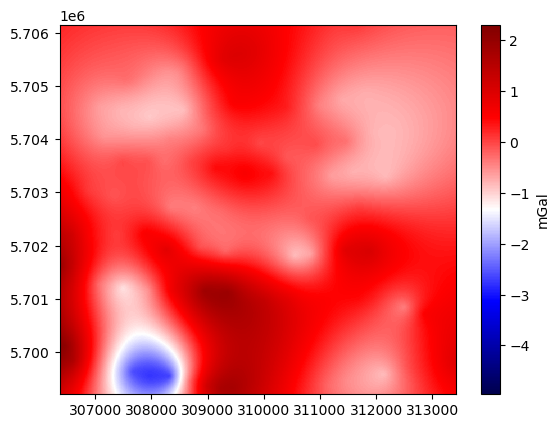

In [74]:
#
plt.figure()
plt.pcolormesh(grid_coords[0], grid_coords[1], grid_residual, cmap="seismic", 
               vmin=dffinal['residual'].min()-1, vmax=dffinal['residual'].max())
plt.colorbar(label="mGal")
plt.show()
#


Spline()


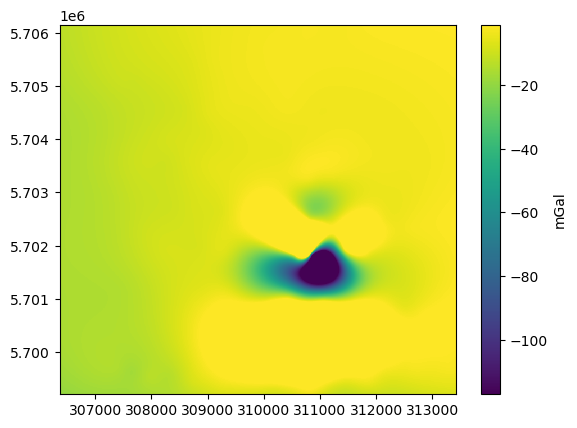

In [75]:
#%% Gridding bouger anomaly
dffinal.dropna(subset=['gravity_bouger_corrected'], inplace=True)
# #verde interpolation
spline = vd.Spline()
# Printing a gridder shows the class and all of it's configuration options.
coordinates = (np.array(dffinal['x']), np.array(dffinal['y']))
print(spline)
spline.fit(coordinates, np.array(dffinal['gravity_bouger_corrected']))
# # Generate coordinates for a regular grid with 10 m grid spacing (assuming
# # coordinates are in meters).
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(region, spacing=10)
grid_bouger = spline.predict(grid_coords)
#
plt.figure()
plt.pcolormesh(grid_coords[0], grid_coords[1], grid_bouger, cmap="viridis", 
               vmin=dffinal['gravity_bouger_corrected'].min()-100, vmax=dffinal['gravity_bouger_corrected'].max())
plt.colorbar(label="mGal")
plt.show()
#


In [76]:
#%% Gridding bouger anomaly Cross Validation try 
dffinal.dropna(subset=['gravity_bouger_corrected'], inplace=True)
# #verde interpolation
spline = vd.SplineCV(dampings=(1e-5, 1e-3, 1e-1), mindists=(10e3, 50e3, 100e3))
# Printing a gridder shows the class and all of it's configuration options.
coordinates = (np.array(dffinal['x']), np.array(dffinal['y']))
print(spline)
spline.fit(coordinates, np.array(dffinal['gravity_bouger_corrected']))
# # Generate coordinates for a regular grid with 10 m grid spacing (assuming
# # coordinates are in meters).
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(region, spacing=100)
grid_bouger = spline.predict(grid_coords)
#


SplineCV(dampings=(1e-05, 0.001, 0.1), mindists=(10000.0, 50000.0, 100000.0))


C:\Users\tgluz\.conda\envs\plot_grav\lib\site-packages\verde\base\base_classes.py:359: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.0.0. This may change model selection results slightly.
  warnings.warn(
C:\Users\tgluz\.conda\envs\plot_grav\lib\site-packages\verde\base\base_classes.py:359: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.0.0. This may change model selection results slightly.
  warnings.warn(
C:\Users\tgluz\.conda\envs\plot_grav\lib\site-packages\verde\base\base_classes.py:359: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.0.0. This may change model selection results slightly.
  warnings.warn(
C:\Users\tgluz\.conda\envs\plot_grav\lib\site-packages\verde\base\base_classes.py:359: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.

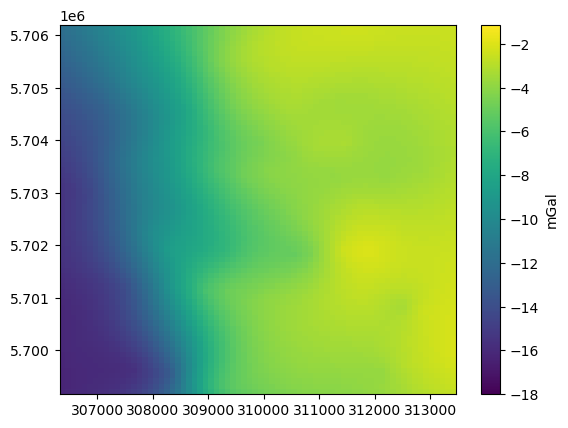

In [77]:
plt.figure()
plt.pcolormesh(grid_coords[0], grid_coords[1], grid_bouger, cmap="viridis", 
               vmin=dffinal['gravity_bouger_corrected'].min()-1, vmax=dffinal['gravity_bouger_corrected'].max())
plt.colorbar(label="mGal")
plt.show()


In [78]:
z=np.array(dffinal['gravity_bouger_corrected'])
y=np.array(dffinal['y'])
x=np.array(dffinal['x'])


In [4]:
dataset = pd.read_csv('C:/RWTH_Aachen/thesis/july_bash/gravity_processed.csv')

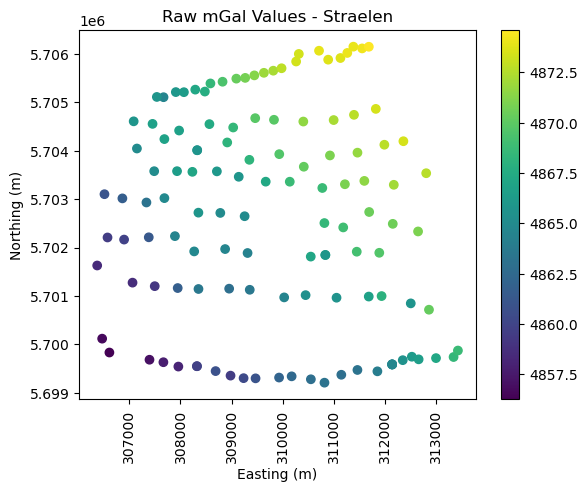

In [7]:
#Plotting the observed value
plt.scatter(dataset['x'], dataset['y'], c=dataset['Observed Value [mGal]'])
plt.colorbar()
plt.title('Raw mGal Values - Straelen' )
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.plot()
plt.xticks(rotation=90)
plt.show()

In [5]:
# Extract the values as a numpy array and concatenate the columns
merged = np.concatenate((dffinal['x'].values.reshape(-1, 1), 
                         dffinal['y'].values.reshape(-1, 1), 
                         dffinal['gravity_bouger_corrected'].values.reshape(-1, 1)), 
                        axis=1)

NameError: name 'dffinal' is not defined

In [80]:
X, Y = np.meshgrid(x, y)

In [81]:
dffinal.to_csv('gravity_processed.csv')

NameError: name 'Z' is not defined

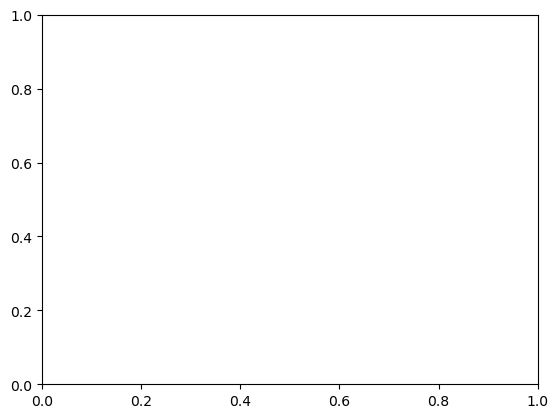

In [82]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS)
ax.set_title('gridding attempt')

In [ ]:
#%%
coordinates = (np.array(dffinal['y']), np.array(dffinal['x']), np.array(dffinal['Ele_tiff']))
eql = hm.EQLHarmonic(damping=100, relative_depth=10)
eql.fit(coordinates, np.array(dffinal.gravity_disturbance))

grid = eql.grid(
    upward=10,
    region=region,
    coordinates=coordinates,
    spacing=10,
    data_names=["gravity_disturbance"],
    dims=("latitude", "longitude"),
    projection=pnew,
)
grid

In [83]:
dffinal


,Point ID,Observed Value [mGal],Time,Voltage [V],Temperature [°C],Altitude,Counter Reading,Remark,Date,Profile,...,gravity_disturbance_comparison,gravity_bouger_corrected,gravity_bouger_corrected1800,gravity_bouger_corrected2000,gravity_bouger_corrected2200,gravity_bouger_corrected2400,gravity_bouger_corrected2600,bouger_rho_delta,regional,residual
0,8001,4864.713210,1900-01-01 13:04:00,12.6,50.0,9,4754.50,Base Station I,6.12.2022,8.0,...,-0.003918,-3.341198,-1.830114,-2.177489,-2.524865,-2.872241,-3.219617,-1.389503,-2.970344,-0.370854
1,8002,4865.533514,1900-01-01 13:14:00,12.6,50.0,13,4755.30,NaN,6.12.2022,8.0,...,-0.003650,-3.150790,-1.742500,-2.066245,-2.389990,-2.713735,-3.037480,-1.294980,-2.910675,-0.240115
2,8003,4866.251280,1900-01-01 13:22:00,12.5,50.0,16,4756.00,NaN,6.12.2022,8.0,...,-0.003504,-2.798564,-1.446642,-1.757429,-2.068215,-2.379002,-2.689789,-1.243147,-2.890922,0.092358
3,8004,4866.456356,1900-01-01 13:32:00,12.5,50.0,18,4756.20,NaN,6.12.2022,8.0,...,-0.003396,-2.778113,-1.467691,-1.768938,-2.070184,-2.371430,-2.672677,-1.204985,-2.882718,0.104606
4,8005,4867.174122,1900-01-01 13:41:00,12.6,50.0,18,4756.90,Changing voltage,6.12.2022,8.0,...,-0.003039,-2.837263,-1.665391,-1.934787,-2.204183,-2.473579,-2.742975,-1.077584,-2.946030,0.108766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,4009,4868.712192,1900-01-01 15:42:00,12.6,49.9,35,4758.40,city centre,19.12.2022,NaN,...,-0.003793,-3.777750,-2.318108,-2.653658,-2.989208,-3.324757,-3.660308,-1.342200,-4.464294,0.686545
120,4010,4867.276660,1900-01-01 15:51:00,12.6,49.9,38,4757.00,city centre,19.12.2022,NaN,...,-0.004095,-4.581974,-3.007134,-3.369166,-3.731198,-4.093230,-4.455263,-1.448130,-5.309931,0.727956
121,4011,4865.789859,1900-01-01 15:55:00,12.6,49.9,41,4755.55,NaN,19.12.2022,NaN,...,-0.004315,-5.685638,-4.027522,-4.408698,-4.789874,-5.171050,-5.552226,-1.524704,-6.430891,0.745253
122,4012,4866.046204,1900-01-01 16:01:00,12.6,49.9,33,4755.80,NaN,19.12.2022,NaN,...,-0.003446,-7.295901,-5.969700,-6.274574,-6.579448,-6.884321,-7.189195,-1.219495,-7.483186,0.187286
